In [1]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import numpy as np
import os, json, cv2, random, copy
import matplotlib.pyplot as plt
import cv2
import time
import datetime

In [19]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

In [33]:
exp_dir_master = '/home/mschoder/experiment_outputs/model_COCO-Detection'
exp_dirs = sorted([x[0] for x in os.walk(exp_dir_master)])
print("Number of dirs: ", len(exp_dirs))
for idx, d in enumerate(exp_dirs):
    print(idx,d)

Number of dirs:  11
0 /home/mschoder/experiment_outputs/model_COCO-Detection
1 /home/mschoder/experiment_outputs/model_COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml_lr_0.00025_iters_750_tf_HLS_EQ_Transform()
2 /home/mschoder/experiment_outputs/model_COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml_lr_0.00025_iters_750_tf_HSV_EQ_Transform()
3 /home/mschoder/experiment_outputs/model_COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml_lr_0.00025_iters_750_tf_NoOpTransform()
4 /home/mschoder/experiment_outputs/model_COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml_lr_0.00025_iters_750_tf_HLS_EQ_Transform()
5 /home/mschoder/experiment_outputs/model_COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml_lr_0.00025_iters_750_tf_HSV_EQ_Transform()
6 /home/mschoder/experiment_outputs/model_COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml_lr_0.00025_iters_750_tf_NDI_CIVE_ExG_Transform()
7 /home/mschoder/experiment_outputs/model_COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml_lr_0.00025_iters_750_tf_NoOpTransform()
8 /home/mschoder/

In [34]:
# Find best metrics

best_ap50 = []

for exp_id in range(1,len(exp_dirs)):
    exp = exp_dirs[exp_id]
    exp_metrics = load_json_arr(exp + '/metrics.json')
    val_loss_metrics = [x for x in exp_metrics if 'total_val_loss' in x]
    bbox_loss_metrics = [x for x in exp_metrics if 'bbox/AP50' in x]
    class_acc_metrics = [x for x in exp_metrics if 'fast_rcnn/cls_accuracy' in x]
    false_neg_metrics = [x for x in exp_metrics if 'fast_rcnn/false_negative' in x]
    
    ap50 = [x['bbox/AP50'] for x in bbox_loss_metrics]
    best_ap50.append(max(ap50))
    
    
print(best_ap50)
    

[31.670758008966153, 31.226682764327297, 31.910264700771663, 28.481715145958862, 28.83976948886194, 14.760618775023904, 29.492531602232713, 31.04843769575159, 30.479312201382395, 32.29812212579236]


Text(0.5, 0, 'Training Iterations')

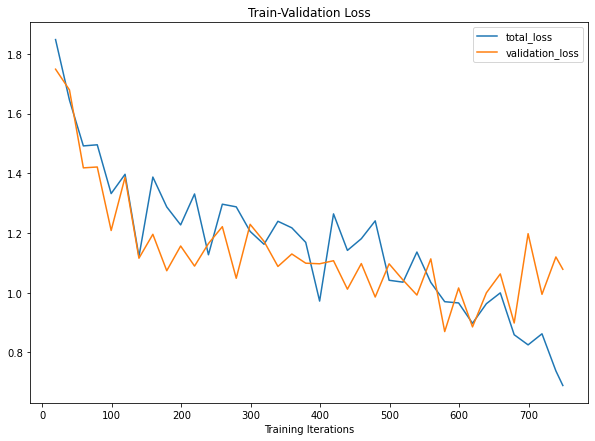

In [15]:
# Plot Train-Validation Loss curve


experiment_folder = exp_dirs[4]



experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

iters = [x['iteration'] for x in experiment_metrics if 'total_val_loss' in x.keys()]
total_losses = [x['total_loss'] for x in experiment_metrics if 'total_val_loss' in x.keys()]
val_losses = [x['total_val_loss'] for x in experiment_metrics if 'total_val_loss' in x]

val_loss_metrics = [x for x in experiment_metrics if 'total_val_loss' in x]
bbox_loss_metrics = [x for x in experiment_metrics if 'bbox/AP50' in x]
class_acc_metrics = [x for x in experiment_metrics if 'fast_rcnn/cls_accuracy' in x]
false_neg_metrics = [x for x in experiment_metrics if 'fast_rcnn/false_negative' in x]



plt.figure(figsize=(10,7))
plt.plot(iters, total_losses)
plt.plot(iters, val_losses)
plt.legend(['total_loss', 'validation_loss'], loc='upper right')
plt.title('Train-Validation Loss')
plt.xlabel('Training Iterations')

In [17]:
ap50 = [x['bbox/AP50'] for x in bbox_loss_metrics]
ap50

[2.0253600618500123,
 8.353947750452887,
 14.635223647941547,
 20.60463911042198,
 25.735756865160802,
 30.92162824518156,
 32.29812212579236,
 31.84575007456152]

In [32]:
exp_metrics

[{'data_time': 0.007447361003869446,
  'eta_seconds': 145.4636576851044,
  'fast_rcnn/cls_accuracy': 0.3662109375,
  'fast_rcnn/false_negative': 0.08265027322404371,
  'fast_rcnn/fg_cls_accuracy': 0.9173497267759563,
  'iteration': 19,
  'loss_box_reg': 0.5354140102863312,
  'loss_cls': 0.7575700283050537,
  'loss_rpn_cls': 0.41493959724903107,
  'loss_rpn_loc': 0.02964712679386139,
  'lr': 4.99525e-06,
  'roi_head/num_bg_samples': 109.375,
  'roi_head/num_fg_samples': 18.625,
  'rpn/num_neg_anchors': 242.75,
  'rpn/num_pos_anchors': 13.25,
  'time': 0.19926528450014303,
  'total_loss': 1.709879009053111,
  'total_val_loss': 1.6552367322146893,
  'val_loss_box_reg': 0.48055675625801086,
  'val_loss_cls': 0.7416194975376129,
  'val_loss_rpn_cls': 0.39395463466644287,
  'val_loss_rpn_loc': 0.0310348067432642},
 {'data_time': 0.00814017799712019,
  'eta_seconds': 144.29245048289886,
  'fast_rcnn/cls_accuracy': 0.8134765625,
  'fast_rcnn/false_negative': 0.8343137254901961,
  'fast_rcnn/fg